In [4]:
!pip install pytorch_forecasting

In [5]:
# from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import pandas as pd
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [6]:
# Đọc dữ liệu
data = pd.read_csv('ALNY_processed.csv')
# Convert 'Date' to datetime và sort
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Giữ lại bản sao của cột ngày gốc
original_dates = data['Date'].copy()

# Chuyển đổi ngày thành chỉ số số nguyên
data['Date'] = np.arange(0, data.shape[0])
data['series'] = 0  # single series

In [7]:
# Parameters
max_encoder_length = 180
def prepare_data(data, split_ratio, max_encoder_length):
  # Split data into train and test sets based on a 80/20 ratio
  train_size = int(len(data) * split_ratio)

  train_data = data.iloc[:train_size]
  test_data = data.iloc[train_size - max_encoder_length:]  # Include overlap for encoder length
  return train_data, test_data, train_size

In [8]:
# Load the best model
def train_nbeats_model(train_data, test_data, max_prediction_length, train_size, max_encoder_length):
  # Create TimeSeriesDataSet for training
  training = TimeSeriesDataSet(
      train_data,
      time_idx="Date",
      target="Adj Close",
      categorical_encoders={"series": NaNLabelEncoder().fit(train_data.series)},
      group_ids=["series"],
      time_varying_unknown_reals=["Adj Close"],
      max_encoder_length=max_encoder_length,
      max_prediction_length=max_prediction_length,
  )

  # Create TimeSeriesDataSet for testing
  testing = TimeSeriesDataSet.from_dataset(training, test_data, min_prediction_idx=train_size)

  # DataLoader
  batch_size = 32
  train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)
  test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=3)

  # Trainer setup
  early_stop_callback = EarlyStopping(monitor="train_loss_epoch", min_delta=1e-4, patience=10, verbose=False, mode="min")
  trainer = pl.Trainer(
      max_epochs=30,
      accelerator="auto",
      enable_model_summary=True,
      gradient_clip_val=0.01,
      log_every_n_steps=10,
      limit_train_batches=150,
      callbacks=[early_stop_callback]
  )

  # Initialize NBeats model
  net = NBeats.from_dataset(
      training,
      learning_rate=1e-3,
      log_interval=10,
      log_val_interval=1,
      weight_decay=1e-2,
      widths=[32, 512],
      backcast_loss_ratio=1.0,
  )

  # Train the model
  trainer.fit(
      net,
      train_dataloaders=train_dataloader,
  )

  # Load the best model
  best_model_path = trainer.checkpoint_callback.best_model_path
  best_model = NBeats.load_from_checkpoint(best_model_path)
  return best_model, test_dataloader, training



In [9]:
def evaluate_model(best_model, test_data, test_dataloader, max_prediction_length, train_size):
  # Make predictions on the test set
  predictions = best_model.predict(test_dataloader)

  # Extract true values for comparison
  true_values = test_data.loc[test_data['Date'] >= train_size, 'Adj Close'].values[:max_prediction_length]

  # Flatten the predicted values
  predicted_values = predictions.numpy().flatten()[:len(true_values)]

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
  print(f"RMSE on test set: {rmse}")

  # Calculate MAE
  mae = mean_absolute_error(true_values, predicted_values)
  print(f"MAE on test set: {mae}")

  # Calculate MAPE
  mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
  print(f"MAPE on test set: {mape}")

  # Convert predictions to a DataFrame for comparison
  test_dates = original_dates.iloc[train_size:train_size + max_prediction_length]
  predicted_df = pd.DataFrame({"Date": test_dates, "Predicted Price": predicted_values})

  # Extract true values to DataFrame for comparison
  true_df = pd.DataFrame({"Date": test_dates, "True Price": true_values})

  # Merge predictions and true values for evaluation
  evaluation_df = pd.merge(predicted_df, true_df, on="Date")
  return evaluation_df


In [10]:
# Function to make future predictions
def predict_nbeats_model(best_model, training, data, max_prediction_length):
    # Prepare data for prediction
    last_data = data.tail(max_encoder_length).copy()
    last_data_dates = np.arange(len(data), len(data) + max_prediction_length)

    # Forward fill the Adj Close column for future dates
    future_data = pd.DataFrame({
        'Date': last_data_dates,
        'series': 0,
        'Adj Close': [last_data['Adj Close'].iloc[-1]] * max_prediction_length  # forward fill with last known value
    })

    # Combine the last data with the future data
    prediction_data = pd.concat([last_data, future_data], ignore_index=True)

    # Create a TimeSeriesDataSet for prediction
    prediction_dataset = TimeSeriesDataSet.from_dataset(
        training,
        prediction_data,
        min_prediction_idx=last_data_dates[0]
    )

    # Create DataLoader for prediction
    prediction_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

    # Make predictions
    predictions = best_model.predict(prediction_dataloader)

    # Convert predictions to a DataFrame
    last_date = original_dates.max()
    predicted_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=max_prediction_length)
    predicted_prices = predictions.numpy().flatten()
    future_df = pd.DataFrame({"Date": predicted_dates, "Predicted Price": predicted_prices})

    return future_df

# **Train Test 8/2**

**Predict next 30 days**

In [ ]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.8, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 14.965548557611731
MAE on test set: 14.138016682942707
MAPE on test set: 7.48899914153271
         Date  Predicted Price  True Price
0  2023-03-01       207.536652      195.40
1  2023-03-02       207.835129      194.44
2  2023-03-03       207.867188      202.58
3  2023-03-04       207.082504      201.62
4  2023-03-05       205.513428      200.66
5  2023-03-06       203.706909      199.70
6  2023-03-07       202.358414      194.34
7  2023-03-08       201.887115      190.41
8  2023-03-09       202.214294      185.95
9  2023-03-10       202.865463      182.66
10 2023-03-11       203.311081      183.39
11 2023-03-12       203.316360      184.13
12 2023-03-13       203.075531      184.86
13 2023-03-14       203.051208      187.10
14 2023-03-15       203.629547      185.75
15 2023-03-16       204.819138      189.66
16 2023-03-17       206.192932      185.45
17 2023-03-18       207.118164      186.14
18 2023-03-19       207.136017      186.83
19 2023-03-20       206.254349  

In [ ]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       159.281586
1  2024-03-02       158.789902
2  2024-03-03       159.043137
3  2024-03-04       160.032532
4  2024-03-05       161.459259
5  2024-03-06       162.882935
6  2024-03-07       163.930435
7  2024-03-08       164.453568
8  2024-03-09       164.558701
9  2024-03-10       164.503220
10 2024-03-11       164.526077
11 2024-03-12       164.711594
12 2024-03-13       164.962524
13 2024-03-14       165.093781
14 2024-03-15       164.987854
15 2024-03-16       164.715134
16 2024-03-17       164.540359
17 2024-03-18       164.799591
18 2024-03-19       165.709137
19 2024-03-20       167.213089
20 2024-03-21       168.963013
21 2024-03-22       170.453598
22 2024-03-23       171.251953
23 2024-03-24       171.201691
24 2024-03-25       170.494446
25 2024-03-26       169.574722
26 2024-03-27       168.936096
27 2024-03-28       168.924744
28 2024-03-29       169.650497
29 2024-03-30       171.030640


**Predict for next 60 days**

In [ ]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.8, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, u

RMSE on test set: 13.687398224943864
MAE on test set: 11.476307566324872
MAPE on test set: 5.935547423106226
         Date  Predicted Price  True Price
0  2023-03-01       201.365997      195.40
1  2023-03-02       202.258911      194.44
2  2023-03-03       203.435120      202.58
3  2023-03-04       204.326538      201.62
4  2023-03-05       204.473846      200.66
5  2023-03-06       203.869659      199.70
6  2023-03-07       203.010162      194.34
7  2023-03-08       202.591492      190.41
8  2023-03-09       203.048660      185.95
9  2023-03-10       204.258682      182.66
10 2023-03-11       205.623428      183.39
11 2023-03-12       206.480072      184.13
12 2023-03-13       206.553772      184.86
13 2023-03-14       206.131699      187.10
14 2023-03-15       205.832245      185.75
15 2023-03-16       206.129303      189.66
16 2023-03-17       206.969147      185.45
17 2023-03-18       207.758408      186.14
18 2023-03-19       207.746765      186.83
19 2023-03-20       206.552719 

In [12]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.8, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 25.544169381921055
MAE on test set: 19.924019571940104
MAPE on test set: 10.236513572538906
         Date  Predicted Price  True Price
0  2023-03-01       199.448074      195.40
1  2023-03-02       201.268402      194.44
2  2023-03-03       202.084579      202.58
3  2023-03-04       201.848099      201.62
4  2023-03-05       201.051941      200.66
..        ...              ...         ...
85 2023-05-25       240.420151      186.00
86 2023-05-26       240.672043      188.26
87 2023-05-27       240.978928      187.81
88 2023-05-28       240.585220      187.36
89 2023-05-29       238.907150      186.91

[90 rows x 3 columns]
         Date  Predicted Price
0  2024-03-01       159.225449
1  2024-03-02       156.877625
2  2024-03-03       156.196014
3  2024-03-04       157.561783
4  2024-03-05       160.264938
..        ...              ...
85 2024-05-25       237.941757
86 2024-05-26       240.718918
87 2024-05-27       244.169983
88 2024-05-28       245.631744
89 2024-05

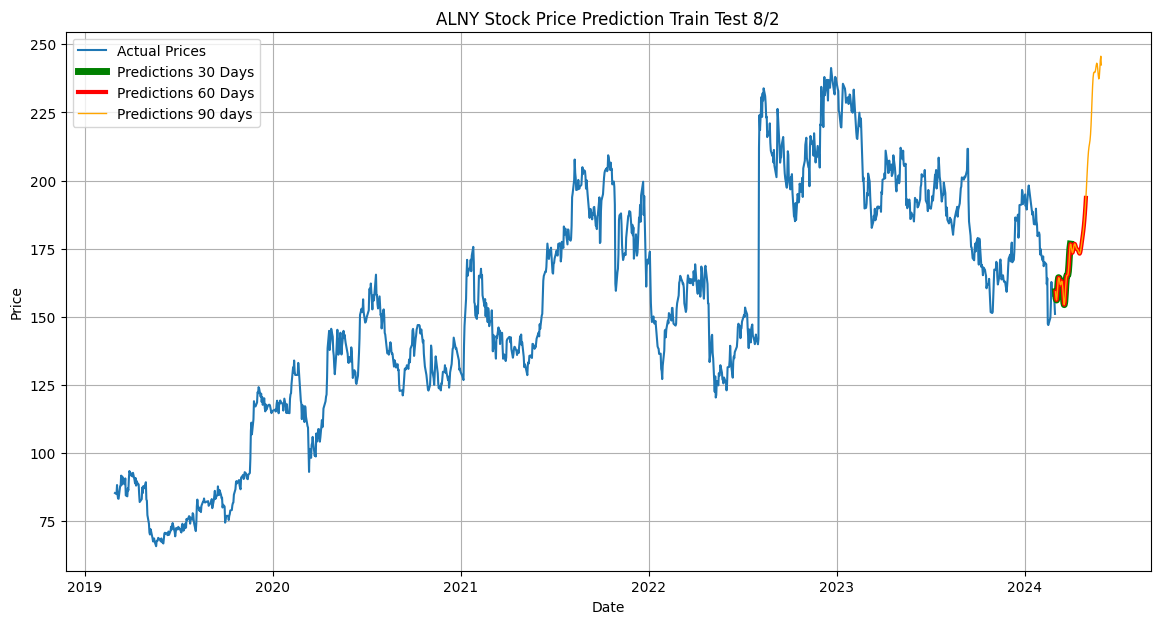

In [13]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ALNY Stock Price Prediction Train Test 8/2')
plt.legend()
plt.grid(True)
plt.show()

# **Train Test 7/3**

**Predict next 30 days**

In [ ]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.7, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 14.414890137828504
MAE on test set: 12.260472432454431
MAPE on test set: 5.936791505241349
         Date  Predicted Price  True Price
0  2022-08-30       219.888702      209.97
1  2022-08-31       222.695221      206.67
2  2022-09-01       224.580872      211.25
3  2022-09-02       225.858597      205.45
4  2022-09-03       227.076172      204.40
5  2022-09-04       228.702972      203.35
6  2022-09-05       230.761002      202.31
7  2022-09-06       232.679504      201.26
8  2022-09-07       233.544861      208.86
9  2022-09-08       232.649078      226.30
10 2022-09-09       229.999817      223.27
11 2022-09-10       226.432709      219.51
12 2022-09-11       223.206635      215.76
13 2022-09-12       221.313263      212.00
14 2022-09-13       220.940186      206.59
15 2022-09-14       221.440063      208.28
16 2022-09-15       221.817169      208.48
17 2022-09-16       221.389984      213.00
18 2022-09-17       220.173264      214.00
19 2022-09-18       218.734253 

In [ ]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       158.413910
1  2024-03-02       159.017563
2  2024-03-03       160.144180
3  2024-03-04       161.449188
4  2024-03-05       162.553101
5  2024-03-06       163.192963
6  2024-03-07       163.326447
7  2024-03-08       163.145432
8  2024-03-09       162.988312
9  2024-03-10       163.181854
10 2024-03-11       163.881897
11 2024-03-12       164.993744
12 2024-03-13       166.222031
13 2024-03-14       167.230911
14 2024-03-15       167.827194
15 2024-03-16       168.056290
16 2024-03-17       168.150360
17 2024-03-18       168.363342
18 2024-03-19       168.808228
19 2024-03-20       169.413498
20 2024-03-21       170.031433
21 2024-03-22       170.613510
22 2024-03-23       171.305130
23 2024-03-24       172.360336
24 2024-03-25       173.912430
25 2024-03-26       175.764709
26 2024-03-27       177.385162
27 2024-03-28       178.166122
28 2024-03-29       177.819046
29 2024-03-30       176.647385


**Predict for next 60 days**

In [ ]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.7, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 32.27086432718909
MAE on test set: 25.87382173665365
MAPE on test set: 13.139985007735527
         Date  Predicted Price  True Price
0  2022-08-30       217.423859      209.97
1  2022-08-31       221.576004      206.67
2  2022-09-01       226.048431      211.25
3  2022-09-02       229.189026      205.45
4  2022-09-03       230.076813      204.40
5  2022-09-04       228.845154      203.35
6  2022-09-05       226.374298      202.31
7  2022-09-06       223.660950      201.26
8  2022-09-07       221.337219      208.86
9  2022-09-08       219.617645      226.30
10 2022-09-09       218.580276      223.27
11 2022-09-10       218.428635      219.51
12 2022-09-11       219.436615      215.76
13 2022-09-12       221.593384      212.00
14 2022-09-13       224.278336      206.59
15 2022-09-14       226.340302      208.28
16 2022-09-15       226.669281      208.48
17 2022-09-16       224.936401      213.00
18 2022-09-17       221.964569      214.00
19 2022-09-18       219.373306  

**Predict for next 90 days**

In [ ]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.7, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90.head(90))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 25.28900343493964
MAE on test set: 19.296931471082903
MAPE on test set: 9.71331908063126
         Date  Predicted Price  True Price
0  2022-08-30       213.365738      209.97
1  2022-08-31       216.333374      206.67
2  2022-09-01       220.173767      211.25
3  2022-09-02       223.689011      205.45
4  2022-09-03       225.847946      204.40
..        ...              ...         ...
85 2022-11-23       211.098740      208.49
86 2022-11-24       213.774475      210.61
87 2022-11-25       216.844147      212.72
88 2022-11-26       217.293732      211.55
89 2022-11-27       212.631592      210.37

[90 rows x 3 columns]
         Date  Predicted Price
0  2024-03-01       157.787094
1  2024-03-02       156.696167
2  2024-03-03       157.064850
3  2024-03-04       158.596527
4  2024-03-05       160.354248
..        ...              ...
85 2024-05-25       246.911072
86 2024-05-26       248.155014
87 2024-05-27       249.173431
88 2024-05-28       247.856445
89 2024-05-29

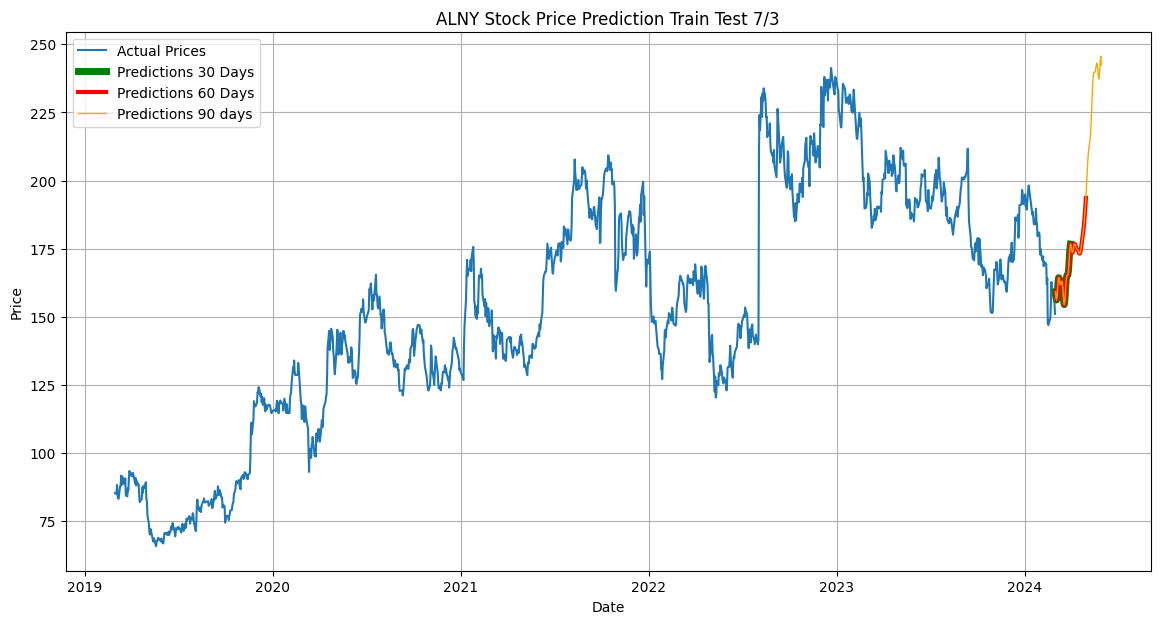

In [14]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ALNY Stock Price Prediction Train Test 7/3')
plt.legend()
plt.grid(True)
plt.show()

# **Train Test 6/4**

**Predict next 30 days**

In [ ]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.6, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 11.631772080162381
MAE on test set: 9.135190897623696
MAPE on test set: 5.654549843164989
         Date  Predicted Price  True Price
0  2022-03-01       167.679596      162.51
1  2022-03-02       168.859665      163.20
2  2022-03-03       168.435074      165.07
3  2022-03-04       167.012039      164.44
4  2022-03-05       165.610626      163.96
5  2022-03-06       164.888947      163.48
6  2022-03-07       164.759811      163.00
7  2022-03-08       164.627853      162.00
8  2022-03-09       163.988998      162.23
9  2022-03-10       162.882965      160.56
10 2022-03-11       161.851364      154.96
11 2022-03-12       161.475204      153.91
12 2022-03-13       161.902390      152.85
13 2022-03-14       162.767426      151.80
14 2022-03-15       163.562622      152.92
15 2022-03-16       164.135422      158.97
16 2022-03-17       164.870911      163.08
17 2022-03-18       166.376862      165.25
18 2022-03-19       168.911942      164.31
19 2022-03-20       172.040649  

In [ ]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       158.435608
1  2024-03-02       158.418930
2  2024-03-03       159.542404
3  2024-03-04       161.042236
4  2024-03-05       162.409912
5  2024-03-06       163.582703
6  2024-03-07       164.760834
7  2024-03-08       166.056290
8  2024-03-09       167.275208
9  2024-03-10       168.000656
10 2024-03-11       167.902161
11 2024-03-12       167.030106
12 2024-03-13       165.873398
13 2024-03-14       165.134827
14 2024-03-15       165.369080
15 2024-03-16       166.707169
16 2024-03-17       168.814636
17 2024-03-18       171.078033
18 2024-03-19       172.894485
19 2024-03-20       173.915955
20 2024-03-21       174.160858
21 2024-03-22       173.980728
22 2024-03-23       173.913147
23 2024-03-24       174.464767
24 2024-03-25       175.881790
25 2024-03-26       177.997086
26 2024-03-27       180.254944
27 2024-03-28       181.961075
28 2024-03-29       182.677231
29 2024-03-30       182.546097


**Predict for next 60 days**

In [ ]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.6, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 32.69937224713301
MAE on test set: 30.135129241943353
MAPE on test set: 18.86496313851925
         Date  Predicted Price  True Price
0  2022-03-01       169.522446      162.51
1  2022-03-02       173.185028      163.20
2  2022-03-03       175.783478      165.07
3  2022-03-04       176.650223      164.44
4  2022-03-05       175.788284      163.96
5  2022-03-06       173.864075      163.48
6  2022-03-07       171.896576      163.00
7  2022-03-08       170.819794      162.00
8  2022-03-09       171.133377      162.23
9  2022-03-10       172.780457      160.56
10 2022-03-11       175.266052      154.96
11 2022-03-12       177.923767      153.91
12 2022-03-13       180.196030      152.85
13 2022-03-14       181.814072      151.80
14 2022-03-15       182.819641      152.92
15 2022-03-16       183.445374      158.97
16 2022-03-17       183.930817      163.08
17 2022-03-18       184.382675      165.25
18 2022-03-19       184.762543      164.31
19 2022-03-20       185.008240  

In [15]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.6, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 55.10249613149094
MAE on test set: 51.84569805908203
MAPE on test set: 35.8011114891563
         Date  Predicted Price  True Price
0  2022-03-01       160.847382      162.51
1  2022-03-02       164.161453      163.20
2  2022-03-03       170.034943      165.07
3  2022-03-04       176.698959      164.44
4  2022-03-05       182.151276      163.96
..        ...              ...         ...
85 2022-05-25       192.704651      126.75
86 2022-05-26       189.864990      125.60
87 2022-05-27       189.535156      127.77
88 2022-05-28       193.339035      127.28
89 2022-05-29       200.662323      126.78

[90 rows x 3 columns]


In [ ]:
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       161.961014
1  2024-03-02       164.324478
2  2024-03-03       165.041412
3  2024-03-04       164.066940
4  2024-03-05       162.312378
..        ...              ...
85 2024-05-25       232.124329
86 2024-05-26       235.550903
87 2024-05-27       240.638855
88 2024-05-28       243.652893
89 2024-05-29       240.183411

[90 rows x 2 columns]


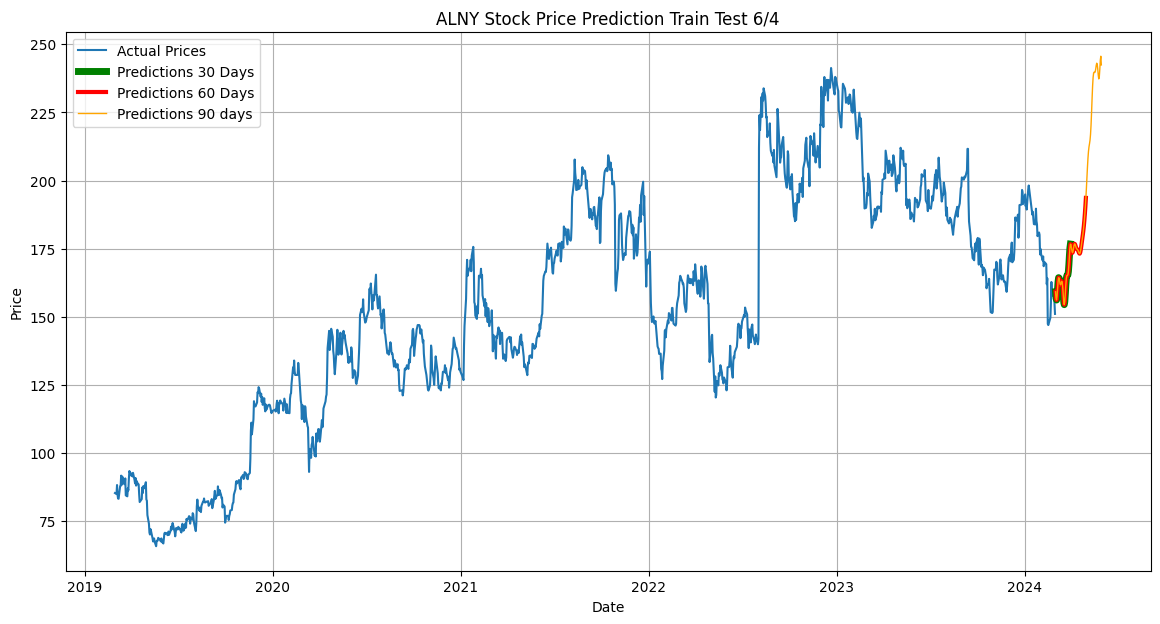

In [16]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ALNY Stock Price Prediction Train Test 6/4')
plt.legend()
plt.grid(True)
plt.show()